In [1]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info(channel_func, channel_pars, channel_args, dm_ini, pars, n_layers, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations. """

    n_inp = int(log2(len(dm_ini)))
    n_tot = n_inp*n_copies

    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_n = []
    dms_n_p = []
    dms_n_m = []
    for p in channel_pars:
        dm_n = reduce(kron, [channel_func(dm_ini, p, *channel_args)]*n_copies)
        dm_n_p = reduce(kron, [channel_func(dm_ini, p+dp, *channel_args)]*n_copies)
        dm_n_m = reduce(kron, [channel_func(dm_ini, p-dp, *channel_args)]*n_copies)
        dms_n.append(dm_n)
        dms_n_p.append(dm_n_p)
        dms_n_m.append(dm_n_m)

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(channel_pars)): # take a density matrix from the training set
        probs = [trace(dms_n[j]@proj).real for proj in projs_u]
        probs_der = [trace((dms_n_p[j] - dms_n_m[j])@proj).real/(2*dp) for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        QFI = 2*(1 - sqrt(fidelity(dms_n_m[j], dms_n_p[j]))) / dp**2 + 1e-10 # via centered differences 
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
        QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

# Single copy

In [36]:
# channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"
# channel_func = z_rot; channel_args = [0]; channel_name = "zrot"
channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

# sv_ini = array(rand_ket(2))
# dm_ini = outer(sv_ini, sv_ini.conj().T)
# dm_ini = array(qp.rand_dm_hs(2))
# dm_ini = eye(2)/2
dm_ini = (eye(2) + X)/2
# dm_ini = (eye(2) + Z)/2

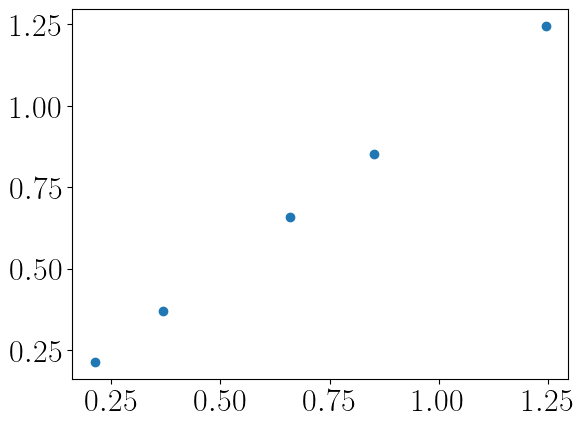

In [37]:
a = 1e-3
b = 4/3 - 1e-3

# labels_train = linspace(a, b, 11)#[1:-1]
labels_train = np.sort(uniform(a, b, 5))
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]

labels_test = linspace(a, b, 15)
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

plt.scatter(labels_train, labels_train)

In [38]:
method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1

w_ls = 1
w_var = 1e-4

dp = 1e-5

x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])

fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
               w_ls=w_ls, w_var=w_var, x0=x0, options={})
pars = result.x

expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(channel_func, labels_train, 
                                                                               channel_args, dm_ini, pars, n_layers,
                                                                               n_copies=n_copies, n_meas=n_meas, dp=dp)

print("\n", result.message)

Iteration: 42 | Function value: 0.00037804
 Optimization terminated successfully.


In [39]:
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(channel_func, labels_test, 
                                                                          channel_args, dm_ini, pars, n_layers,
                                                                          n_copies=n_copies, n_meas=n_meas, dp=dp)

In [40]:
save_path = r"/home/kardashin/Work/QPE/Results/Channels/"
file_info = channel_name + r"-n_copies=%d-n_meas=%d=n_layers=%d-w_ls=%f-w_var=%f" %(n_copies, n_meas, n_layers, w_ls, w_var)
save_path + file_info

'/home/kardashin/Work/QPE/Results/Channels/depolarizing-n_copies=1-n_meas=1=n_layers=1-w_ls=1.000000-w_var=0.000100'

Cost: 0.00037804142865237544

n_copies: 1 | n_meas: 1 | n_layers: 1
w_ls: 1.000000 | w_var: 0.000100 

Sum error: 5.485013648012121e-08


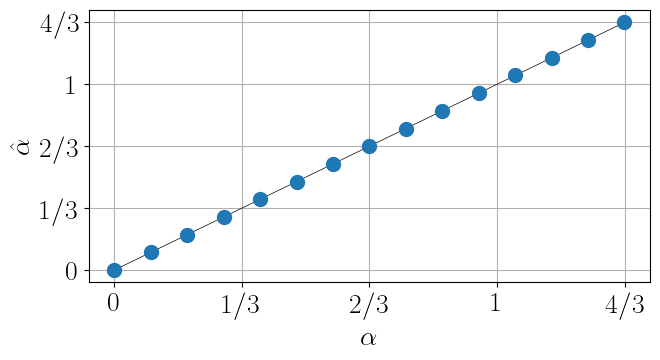

Sum var: 0.7192635778418167
Sum difference: 0.0010103165435383884
Least squares: 1.5155243422385747e-05


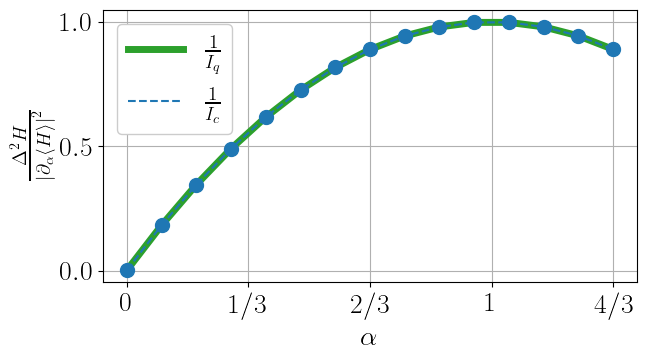

In [41]:
print("Cost:", result.fun)
print("\nn_copies: %d | n_meas: %d | n_layers: %d" %(n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("\nSum error:", sum(np.abs(labels_test - expecs_test)**2)/len(CFIs_test))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, expecs_test, s=100, zorder=10)
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


print("Sum var:", n_copies*sum(disps_test)/len(CFIs_test))
print("Sum difference:", sum(np.abs(CFIs_test - QFIs_test))/len(CFIs_test))
print("Least squares:", sum((CFIs_test - QFIs_test)**2)/len(CFIs_test))

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, n_copies*disps_test/expecs_der_test**2, s=100, zorder=10)
plt.plot(np.sort(labels_test), n_copies/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
# plt.plot(np.sort(labels_test), [n_copies]*len(QFIs_test), color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(np.sort(labels_test), n_copies/CFIs_test, color="C0", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

## Inversion

/tmp/ipykernel_1794252/879275380.py:2: RankWarning: Polyfit may be poorly conditioned
  f = np.poly1d(np.polyfit(labels_train, expecs_train, m))
/tmp/ipykernel_1794252/879275380.py:3: RankWarning: Polyfit may be poorly conditioned
  f_inv = np.poly1d(np.polyfit(expecs_train, labels_train, m))


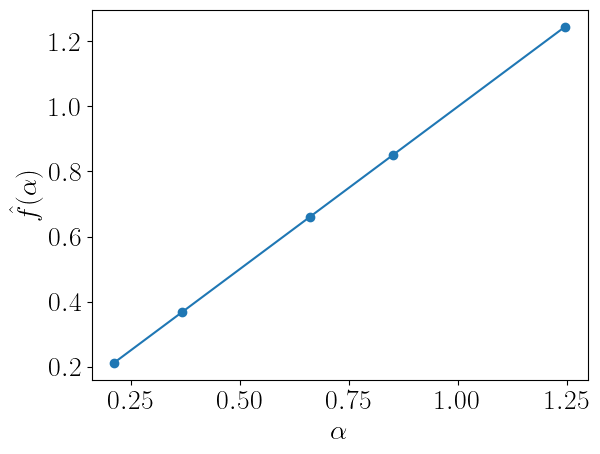

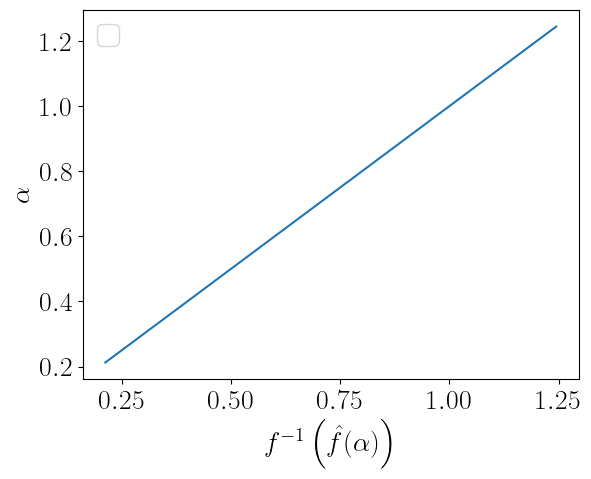

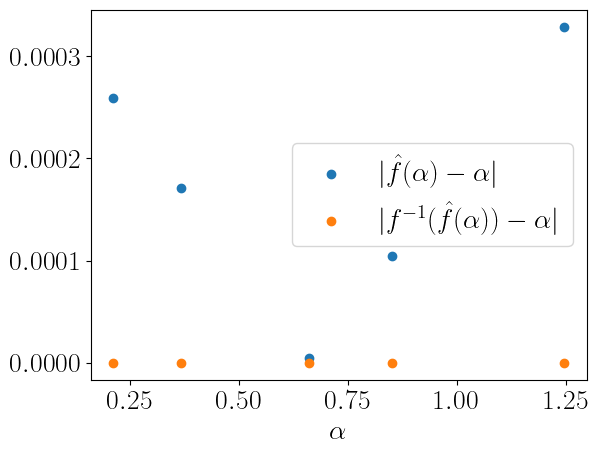

In [42]:
m = 9
f = np.poly1d(np.polyfit(labels_train, expecs_train, m))
f_inv = np.poly1d(np.polyfit(expecs_train, labels_train, m))

plt.scatter(labels_train, expecs_train, label=r"$\hat{\alpha}$")
plt.plot(labels_train, f(labels_train))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{f}(\alpha)$")
# plt.legend()
plt.show()

plt.plot(f_inv(expecs_train), labels_train, label="")
plt.xlabel(r"$f^{-1}\left(\hat{f}(\alpha)\right)$")
plt.ylabel(r"$\alpha$")
plt.legend()
plt.show()

# plt.ylabel(r"$|\hat{\alpha} - \alpha|$")
plt.scatter(labels_train, np.abs(labels_train - expecs_train),  label=r"$|\hat{f}(\alpha) - \alpha|$")
plt.scatter(labels_train, np.abs(labels_train - f_inv(expecs_train)), label=r"$|f^{-1}(\hat{f}(\alpha)) - \alpha|$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

# Multiple copies

In [18]:
# channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"
channel_func = z_rot; channel_args = [0]; channel_name = "zrot"
# channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

# sv_ini = array(rand_ket(2))
# dm_ini = outer(sv_ini, sv_ini.conj().T)
# dm_ini = array(qp.rand_dm_hs(2))
# dm_ini = eye(2)/2
dm_ini = (eye(2) + X)/2
# dm_ini = (eye(2) + Z)/2

In [35]:
a = 1e-3
b = pi - 1e-3

# labels_train = linspace(a, b, 11)#[1:-1]
labels_train = np.sort(uniform(a, b, 10))
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]

labels_test = linspace(a, b, 15)
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

In [30]:
method = "BFGS"
w_ls = 1
w_var = 1e-4

n_copies_list = [1, 2]#, 3, 4]
n_layers_list = [1, 2]#, 1, 1]

pars_list = []
for n_copies, n_layers in zip(n_copies_list, n_layers_list):
    print("n_copies:", n_copies)
    n_inp = int(log2(len(dm_ini)))
    n_meas = n_inp*n_copies
    x0 = concatenate([uniform(0, pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), uniform(-0.1, 0.1, 2**n_meas)])
    fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
                          w_ls=w_ls, w_var=w_var, x0=x0, options={})
    pars = result.x
    pars_list.append(pars)
    print("\n", result.message)
    print()

n_copies: 1
Iteration: 115 | Function value: 0.14936307
 Optimization terminated successfully.

n_copies: 2
Iteration: 375 | Function value: 0.00086662
 Optimization terminated successfully.



In [31]:
dp = 1e-5
aux_infos_list = []
for i in range(len(n_copies_list)):
    n_meas = int(log2(len(dm_ini)))*n_copies_list[i]
    expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(channel_func, labels_test, channel_args, dm_ini, 
                                                                              pars_list[i], n_layers_list[i], n_copies=n_copies_list[i], n_meas=n_meas, dp=dp)
    aux_infos_list.append([expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test])

In [32]:
save_path = r"/home/kardashin/Work/QPE/Results/Channels/"
file_info = channel_name + "-c=(" + ",".join([str(c) for c in n_copies_list]) + ")-" + "l=(" + ",".join([str(l) for l in n_layers_list]) + ")"
save_path + file_info

'/home/kardashin/Work/QPE/Results/Channels/zrot-c=(1,2)-l=(1,2)'

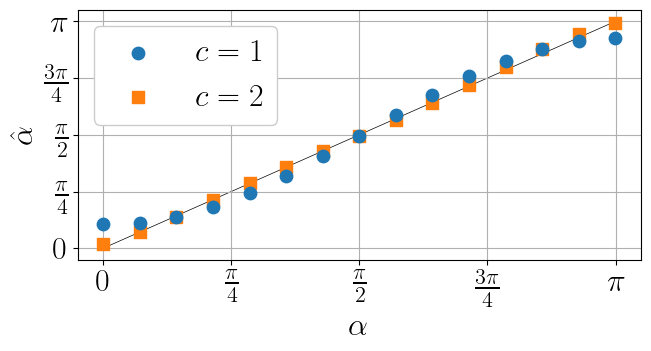

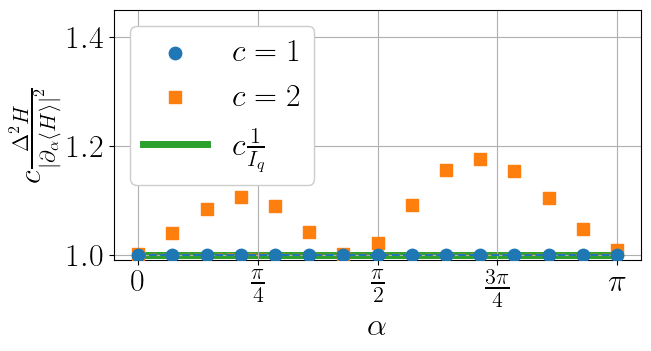

In [33]:
matplotlib.rcParams.update({'font.size': 23})

markers = ["o", "s", "^"]

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
for i in range(len(n_copies_list)):
    plt.scatter(labels_test, aux_infos_list[i][0], s=80, zorder=10-i, marker=markers[i], label=r"$c=%d$" %n_copies_list[i])
plt.plot(labels_test, labels_test, color="black", linewidth=0.5, zorder=0)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{\alpha}$")
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
plt.yticks([0, pi/4, pi/2, 3*pi/4, pi], [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 4))
for i in range(len(n_copies_list)):
    plt.scatter(labels_test, n_copies_list[i]*aux_infos_list[i][2]/aux_infos_list[i][1]**2, zorder=10-i, s=80, marker=markers[i], label=r"$c=%d$" %n_copies_list[i])
    plt.plot(labels_test, n_copies_list[i]/aux_infos_list[i][3], linestyle="--", zorder=10-i)
# plt.plot(labels_test, n_copies/QFIs_test, color="tab:green", linewidth=5, label=r"$c\frac{1}{I_q}$", zorder=0)
plt.plot(labels_test, [1]*len(labels_test), color="tab:green", linewidth=5, label=r"$c\frac{1}{I_q}$", zorder=0)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$c\frac{\Delta^2 H}{\left| \partial_\alpha \langle H \rangle \right|^2}$" )
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
plt.ylim(ymax=1.45)
plt.grid()
plt.legend(framealpha=1, ncol=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()